# Imports

In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-07-07 12:57:53.803086: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-07-07 12:57:57.518364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 12:57:58.290175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18562 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1c:00.0, compute capability: 8.6


In [3]:
from orbit_generation.constants import EM_MU
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, plot_latent_space_2d
from orbit_generation.stats import plot_histograms_comparison, reduce_dimensions_plot_latent_space
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model import get_optimizer, get_model, extract_plot_and_return_metrics
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-07 12:58:05.544361: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-07 12:58:05.546217: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7671690


In [4]:
import numpy as np
import tsgm
import os

# Parameters

In [5]:
want_to_train = True        # Set this parameter to False if you want to load the model from the folder
want_to_generate = True     # Set this parameter to False if you want to load the generation from the folder
calculate_metrics = True    # Set this parameter to False if you don't want to calculate any metric

In [6]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [7]:
params = {
    'model_name': 'timeGAN',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 8,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    },
    'loss': 'mse',
    'num_samples': 100
}

In [8]:
if want_to_train:
    # Initialize a new run
    wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

## Shuffle

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
shuffled_data = data[indices]
labels = np.array(labels)
shuffled_labels = labels[indices]

## Transpose

In [ ]:
transposed_orbits = np.transpose(shuffled_data, (0, 2, 1))

## Scaling

In [ ]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 100, 7)

# Modelling

In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

def get_model(params):
    model_name = params['model_name']

    if model_name == 'vae_conv5':
        architecture = tsgm.models.zoo[model_name](
            seq_len=params['seq_len'], 
            feat_dim=params['feature_dim'], 
            latent_dim=params['latent_dim']
        )

        encoder, decoder = architecture.encoder, architecture.decoder
        vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
        optimizer = Adam(learning_rate=params['optimizer']['learning_rate'])
        vae.compile(optimizer=optimizer, loss=MeanSquaredError())  # Use the MeanSquaredError loss function
        return vae

    elif model_name == 'timeGAN':
        model = tsgm.models.timeGAN.TimeGAN(
            seq_len=params['seq_len'],
            module="gru",
            hidden_dim=params['latent_dim'],
            n_features=params['feature_dim'],
            n_layers=3,
            batch_size=params['batch_size'],
            gamma=1.0,
        )

        # Create optimizers
        d_optimizer = Adam(learning_rate=params['optimizer']['learning_rate'])
        g_optimizer = Adam(learning_rate=params['optimizer']['learning_rate'])
        emb_optimizer = Adam(learning_rate=params['optimizer']['learning_rate'])
        supgan_optimizer = Adam(learning_rate=params['optimizer']['learning_rate'])
        ae_optimizer = Adam(learning_rate=params['optimizer']['learning_rate'])

        # Compile the model with specific optimizers and loss functions
        model.compile(
            d_optimizer=d_optimizer,
            g_optimizer=g_optimizer,
            emb_optimizer=emb_optimizer,
            supgan_optimizer=supgan_optimizer,
            ae_optimizer=ae_optimizer,
            emb_loss=MeanSquaredError(),
            clf_loss=BinaryCrossentropy()
        )
        return model

    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

In [ ]:
if want_to_train:
    model = get_model(params)
    metrics = {}

    # Fit the model using the scaled data and parameters from the dictionary
    history = model.fit(
        scaled_data, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_split=params['val_split'],  # Adjust the split ratio as needed
        callbacks=[WandbCallback()]
    )

    # Extract, plot, and return metrics
    training_metrics = extract_plot_and_return_metrics(history, validation=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(32, 100, 7)]            0         
                                                                 
 Embedder (Sequential)       (32, 100, 8)              1344      
                                                                 
 Recovery (Sequential)       (32, 100, 7)              1359      
                                                                 
Total params: 2,703
Trainable params: 2,703
Non-trainable params: 0
_________________________________________________________________
Model: "AdversarialSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomNoise (InputLayer)    [(32, 100, 7)]            0         
                                                                 
 Generator (Sequential

INFO:models:Start Embedding Network Training
Autoencoder - training: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]
INFO:models:Finished Embedding Network Training
INFO:models:Start Training with Supervised Loss Only
Adversarial Supervised - training: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]
INFO:models:Finished Training with Supervised Loss Only
INFO:models:Start Joint Training
GAN with embedding - training: 100%|██████████| 25/25 [04:14<00:00, 10.19s/it]
INFO:models:Finished Joint Training


AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
# Access the training metrics directly from the model
training_metrics = model.training_losses_history

# Convert to a dictionary or use as needed
metrics_dict = {key: training_metrics[key] for key in training_metrics}
print(metrics_dict)

{'autoencoder': [1.8534445762634277, 1.8068852424621582, 1.7278854846954346, 1.784976840019226, 1.6974974870681763, 1.7262251377105713, 1.728901982307434, 1.678501844406128, 1.6650408506393433, 1.6818499565124512, 1.6689072847366333, 1.618230938911438, 1.6253286600112915, 1.5190865993499756, 1.6033494472503662, 1.6408584117889404, 1.5772491693496704, 1.5899921655654907, 1.5508453845977783, 1.5821133852005005, 1.5401196479797363, 1.5674312114715576, 1.5407301187515259, 1.5596296787261963, 1.4892171621322632], 'adversarial_supervised': [0.16276976466178894, 0.15501821041107178, 0.1476946622133255, 0.14052489399909973, 0.13455511629581451, 0.12858834862709045, 0.12350418418645859, 0.12014879286289215, 0.11559034883975983, 0.11226141452789307, 0.10868064314126968, 0.1052117869257927, 0.10245908796787262, 0.09944276511669159, 0.097163625061512, 0.09372017532587051, 0.09112583845853806, 0.0883464366197586, 0.08594750612974167, 0.0839475616812706, 0.08144889771938324, 0.0786077007651329, 0.07

In [ ]:
model.generate(5)

Synthetic data generation: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


array([[[0.42374146, 0.48598   , 0.49654537, ..., 0.4888693 ,
         0.43727005, 0.4995134 ],
        [0.36240017, 0.46694568, 0.47827932, ..., 0.48181212,
         0.37680256, 0.50635654],
        [0.31104958, 0.46032736, 0.46887434, ..., 0.47656533,
         0.32857373, 0.50957936],
        ...,
        [0.24768028, 0.5132154 , 0.50417674, ..., 0.49451625,
         0.26801878, 0.5082769 ],
        [0.24767202, 0.51317716, 0.50419116, ..., 0.4945154 ,
         0.26802874, 0.50827813],
        [0.24768028, 0.5132154 , 0.50417674, ..., 0.49451625,
         0.26801878, 0.5082769 ]],

       [[0.42374146, 0.48598   , 0.49654537, ..., 0.4888693 ,
         0.43727005, 0.4995134 ],
        [0.36240017, 0.46694568, 0.47827932, ..., 0.48181212,
         0.37680256, 0.50635654],
        [0.31104958, 0.46032736, 0.46887434, ..., 0.47656533,
         0.32857373, 0.50957936],
        ...,
        [0.24768119, 0.5132122 , 0.5041687 , ..., 0.49451214,
         0.26801306, 0.50826865],
        [0.2

## Saving

In [ ]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_2


In [ ]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=training_metrics)

NameError: name 'training_metrics' is not defined

In [ ]:
# Define full paths for saving

generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_data.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_data.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_latent_representations.npy')

In [ ]:
if want_to_train:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        model.encoder.save(encoder_save_path, save_format='tf')
        model.decoder.save(decoder_save_path, save_format='tf')
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model.save(model_save_path, save_format='tf')
else:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        encoder = tf.keras.models.load_model(encoder_save_path)
        decoder = tf.keras.models.load_model(decoder_save_path)
        model = tsgm.models.cvae.BetaVAE(encoder, decoder)
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model = tf.keras.models.load_model(model_save_path)

ValueError: Model <tsgm.models.timeGAN.TimeGAN object at 0x7fdc5a5d7610> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [ ]:
klk

## Generate

In [ ]:
if want_to_generate:
    # Generate the orbits
    generation = model.generate(params['num_samples'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation)
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

Synthetic data generation: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


(100, 100, 7)

# Analysis of Generation

## Visualization

In [ ]:
if generation.shape[2] == 7:
    no_time_generation = generation[:,:,1:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 100, 6)

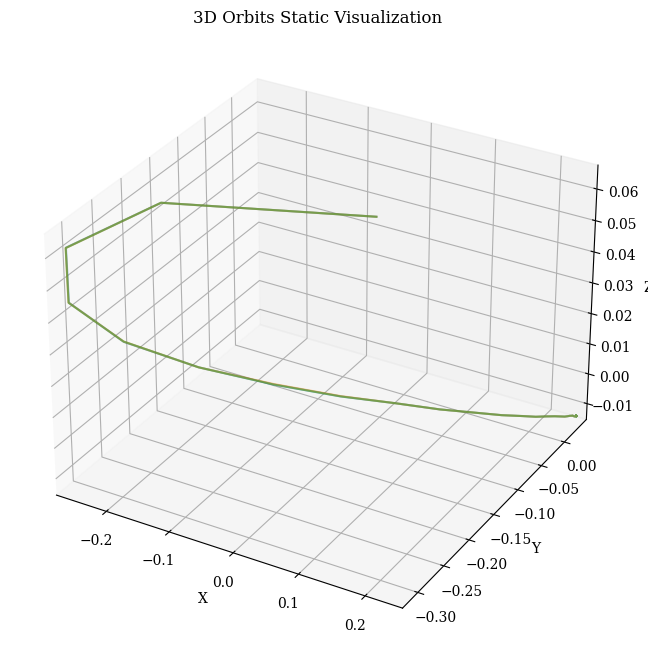

In [ ]:
visualize_static_orbits(data= np.transpose(no_time_generation, (0, 2, 1)), show_legend=False, save_path=static_all_orbit_path,orbit_indices=[0,1,2])

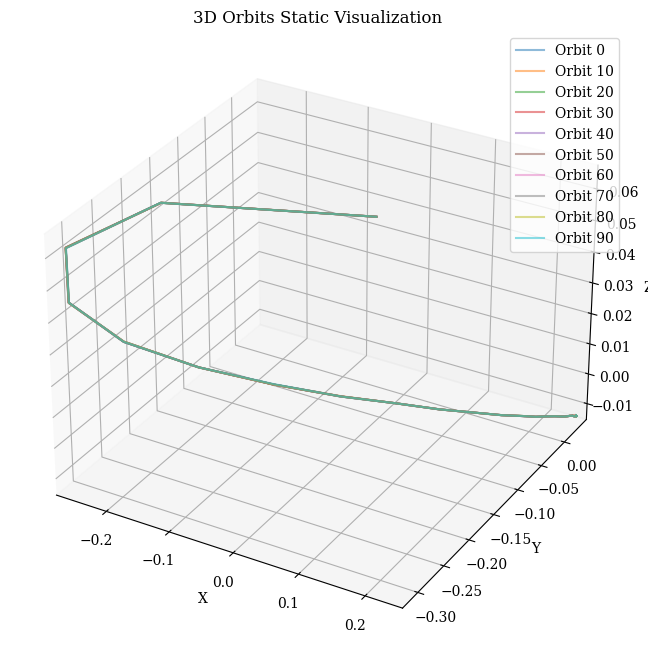

In [ ]:
visualize_static_orbits(data= np.transpose(no_time_generation, (0, 2, 1)), orbit_indices=[0,10,20,30,40,50,60,70,80,90], save_path=static_some_orbit_path)

In [ ]:
export_dynamic_orbits_html(data=np.transpose(no_time_generation, (0, 2, 1)), filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_2/images/exp2_generated_orbits.html


## Coverage

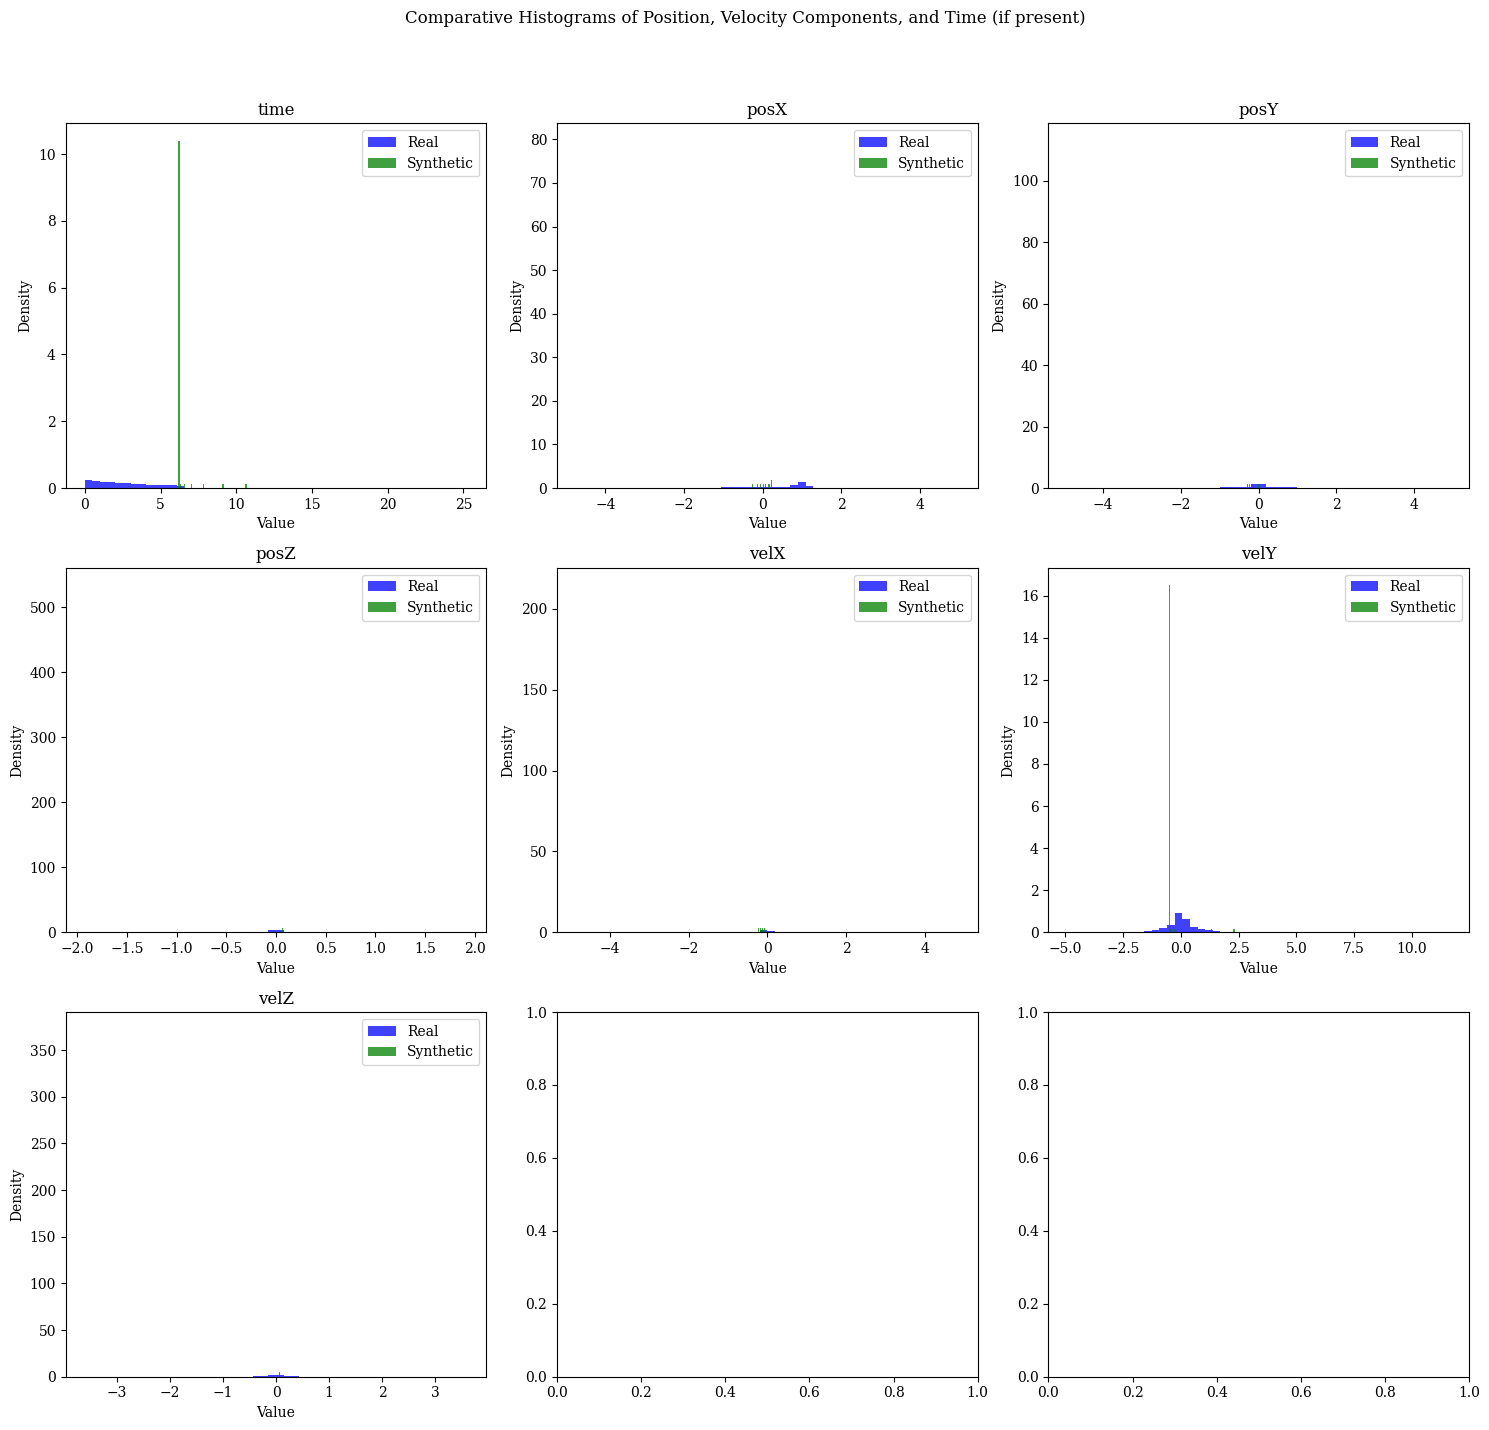

In [ ]:
plot_histograms_comparison(data1=data, data2=np.transpose(generation, (0, 2, 1)), label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

In [ ]:
if calculate_metrics:
    # add model metrics
    transposed_generation=np.transpose(generation, (0, 2, 1))
    reordered_orbits, order_metrics = reorder_orbits(transposed_generation)
    errors = calculate_errors(reordered_orbits,EM_MU)

    # Add metrics
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

ValueError: Time vector is not strictly increasing.

# Latent Visualization

## Sampling

In [ ]:
np.random.seed(42)

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=5000, replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = shuffled_labels[random_indices]

sampled_data.shape

(5000, 300, 7)

In [ ]:
latent_mean, latent_deviation, latent_epsilon = model.encoder(sampled_data)
sampled_latent_representations = latent_mean.numpy()

sampled_latent_representations.shape

(5000, 2)

In [ ]:
sampled_id_classes = [orbit_df.at[index, 'id_class'] for index in sampled_labels]
sampled_classes=get_orbit_classes(sampled_id_classes)

## Orbit Classifications

Saved plot to ../experiments/experiment_1/exp1_sampled_latent_space_label


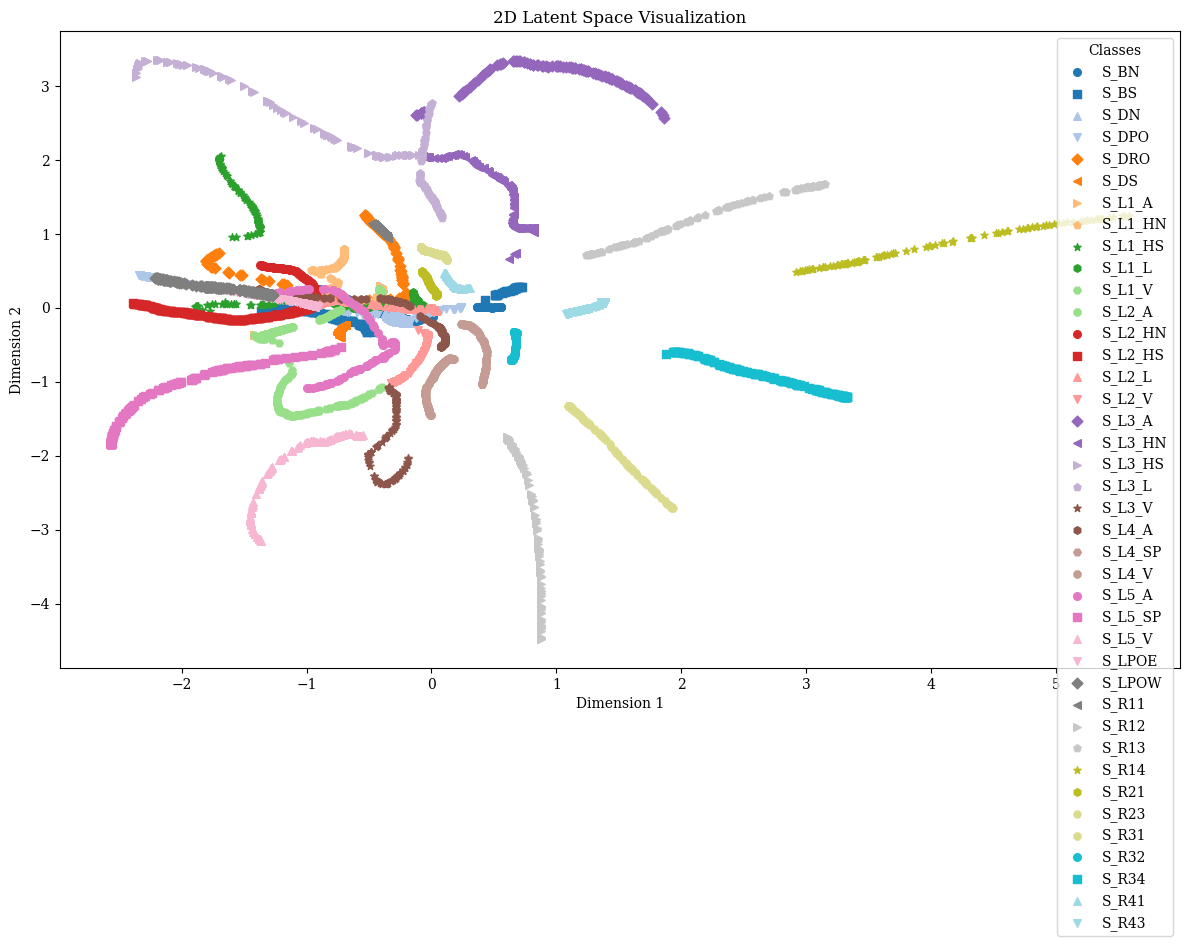

Saved plot to ../experiments/experiment_1/exp1_sampled_latent_space_type


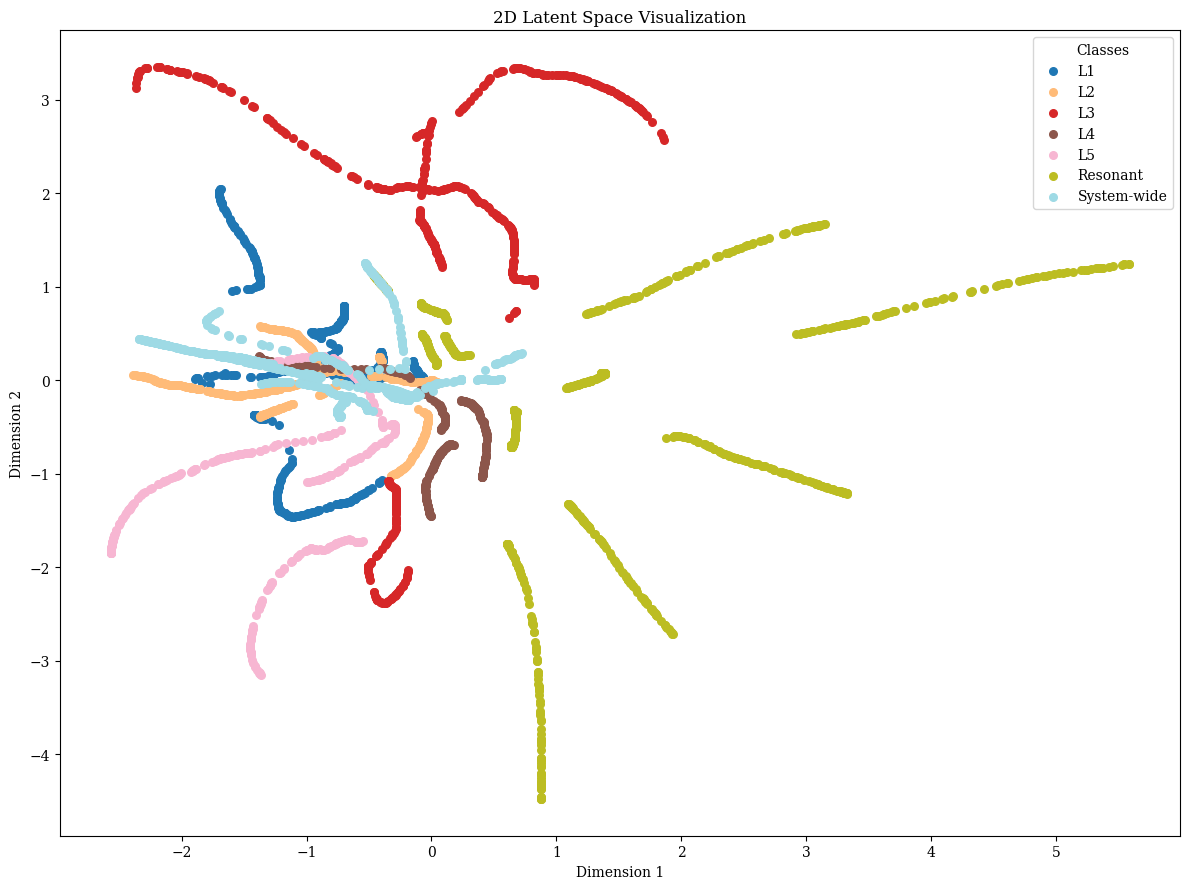

Saved plot to ../experiments/experiment_1/exp1_sampled_latent_space_subtype


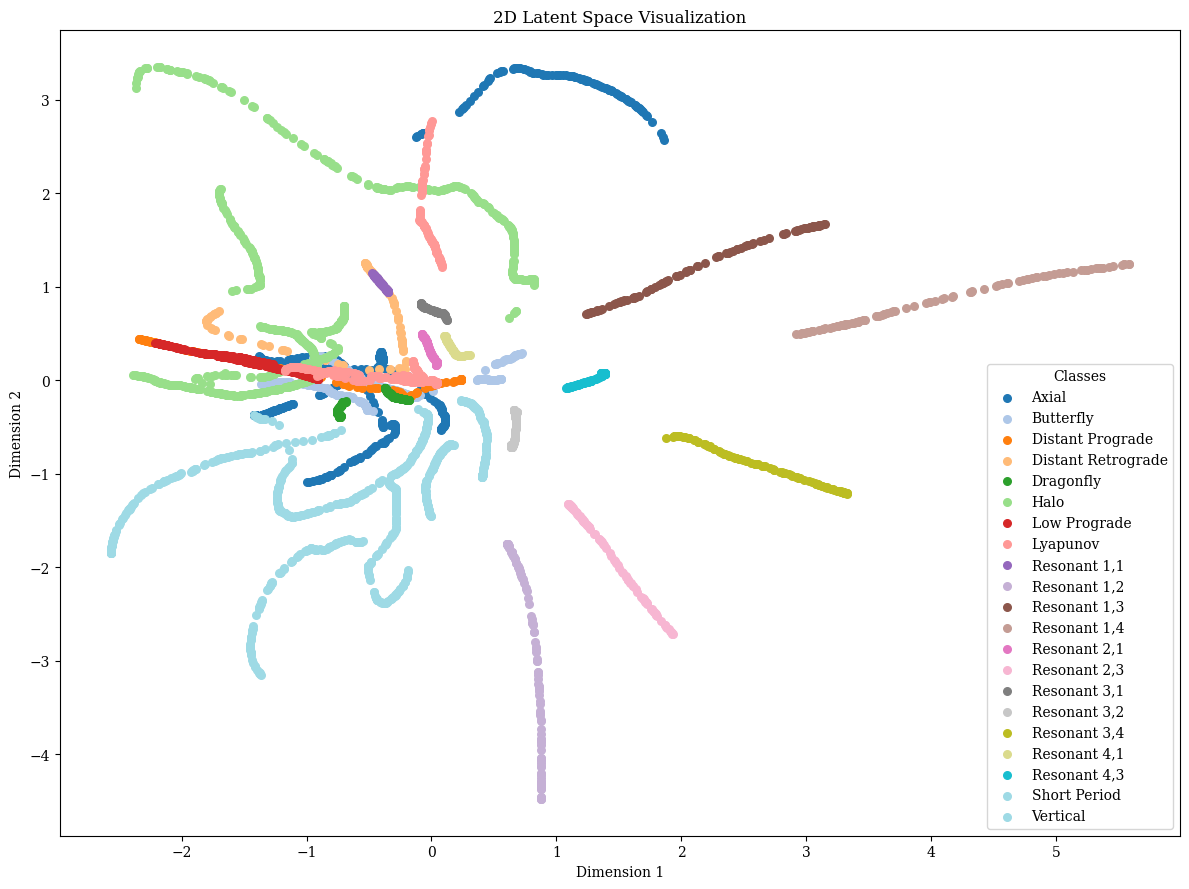

Saved plot to ../experiments/experiment_1/exp1_sampled_latent_space_direction


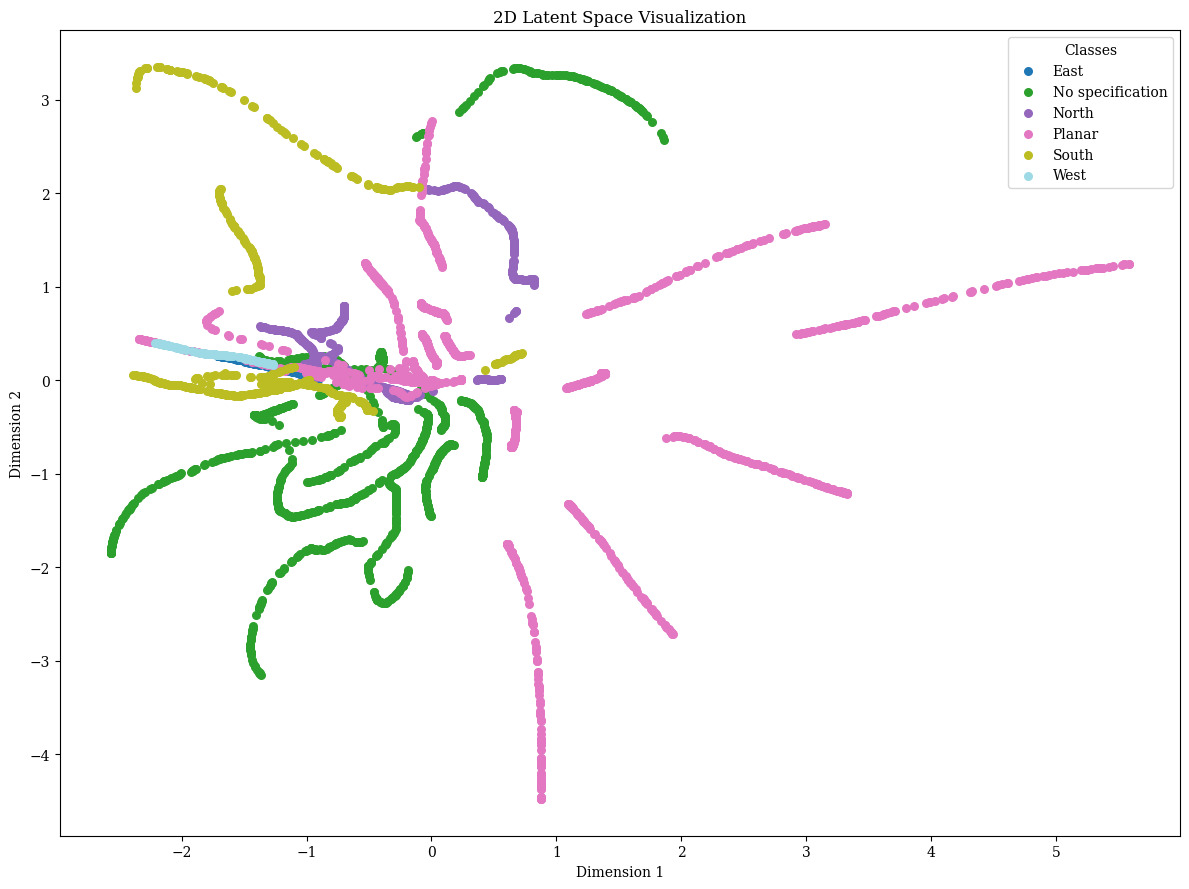

In [ ]:
if sampled_latent_representations.shape[1]==2:
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[0]), many_classes=True)
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[1]))
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[2]))
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[3]))
else:
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[0]), techniques=['PCA','t-SNE','UMAP', 'LDA'], grid_view=False)
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[1]), techniques=['PCA','t-SNE','UMAP', 'LDA'])
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[2]), techniques=['PCA','t-SNE','UMAP', 'LDA'])
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[3]), techniques=['PCA','t-SNE','UMAP', 'LDA'])

In [ ]:
wandb.finish()